In [63]:
#from numba import jit, cuda
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from random import gauss
%matplotlib inline

In [64]:
# HYPERPARAMETERS
S = 50      # students
C = 500     # questions
K = 10       # skills

<AxesSubplot:ylabel='Count'>

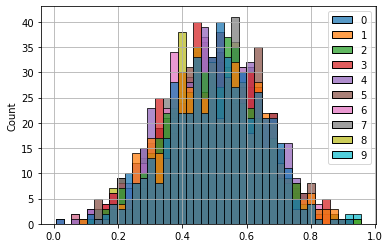

In [65]:
# APPROACH 1 -- Generate Students and Questions as independent variables
lower, upper = 0, 1
s_mu, s_sigma = 0.25, 0.15  # Mean in 0.25 since assumed low initial skills level
q_mu, q_sigma = 0.5, 0.15
students = stats.truncnorm.rvs((lower-s_mu)/s_sigma,(upper-s_mu)/s_sigma,loc=s_mu,scale=s_sigma,size=(S,K))
questions = stats.truncnorm.rvs((lower-q_mu)/q_sigma,(upper-q_mu)/q_sigma,loc=q_mu,scale=q_sigma,size=(C,K))
student_norms = np.linalg.norm(students, axis=1)
question_norms = np.linalg.norm(questions, axis=1)
sns.histplot(questions)

In [66]:
import do_mpc
model_type = 'discrete'
model = do_mpc.model.Model(model_type)
# States
x = model.set_variable(var_type='_x', var_name='x', shape=(K,1))
#z = model.set_variable(var_type='_z', var_name='z', shape=(K,1))
#z2 = model.set_variable(var_type='_z', var_name='z2', shape=(1,1))
# Inputs
u = model.set_variable(var_type='_u', var_name='u', shape=(K,1))
# Outputs
#y = model.set_meas('y', shape=(1,1))

In [67]:
from casadi import *
#x_next = SX()
rhs = []

gamma = 0.8 # Learning rate

alpha = []
#y_tilde = []

for k in range(K):
    # i: student
    # j: content
    # k: skill

    u_k = u[k]  #
    x_k = x[k]

    print("For skill {}, x_ik = {}, and u_jk = {}".format(k, x_k, u_k))
    #print("For skill {}, model data[\'_x\']={}".format(k, vars(model)))

    # alpha: skill deficiency (for all k) of student_i, given knowledge_i and content_j (requirement)
    ## alpha is zero when x_ik > u_jk, between (0,1] otherwise
    alpha_k = fmax(1 - x_k/u_k,0) * u_k # Between 0 and 1
    alpha.append(alpha_k)

# Deficiency and skill norms for estimated performance calculation
alpha_norm = norm_2(vertcat(*alpha))   # but before alpha was a number, you need to do it outside the loop at the end
phi_norm = norm_2(x) # same            

# Estimated performance
y_tilde = fmax(1 - alpha_norm/phi_norm, 0)

for k in range(K):
    u_k = u[k]  #
    x_k = x[k]
    # Knowledge update term
    tau_k   = y_tilde * alpha[k] * gamma * u_k# * (alpha[k] > 0) 
    
    # Append rule to list of right-hand-side equations
    rhs.append(x_k + tau_k)

x_next = vertcat(*rhs)
model.set_rhs('x', x_next)

For skill 0, x_ik = x_0, and u_jk = u_0
For skill 1, x_ik = x_1, and u_jk = u_1
For skill 2, x_ik = x_2, and u_jk = u_2
For skill 3, x_ik = x_3, and u_jk = u_3
For skill 4, x_ik = x_4, and u_jk = u_4
For skill 5, x_ik = x_5, and u_jk = u_5
For skill 6, x_ik = x_6, and u_jk = u_6
For skill 7, x_ik = x_7, and u_jk = u_7
For skill 8, x_ik = x_8, and u_jk = u_8
For skill 9, x_ik = x_9, and u_jk = u_9


In [68]:
model.set_expression(expr_name='cost_x', expr=sum1(x**2))
model.set_expression(expr_name='alpha', expr=fmax(1 - x/u,0) * u)
#model.set_expression(expr_name='y_tilde', expr=circ(fmax(u - x,0)))
#model.set_expression(expr_name='y_tilde_tot', expr=sum1(vertcat(*y_tilde))/K)
#model.set_expression(expr_name='z', expr=u-x)
#model.set_expression(expr_name='cost_x', expr=sum1(fabs(x)))
#model.set_expression(expr_name='cost_u', expr=sum1(fabs(u)))
#model.set_expression(expr_name='z', expr=z-(u-x)) #z-sum1(u-x))
#model.set_alg(expr_name='z', expr=z-(u-x))
#model.set_alg(expr_name='z_upper', expr=sum1(u-x)>0)

SX(@1=1, @2=0, [(fmax((@1-(x_0/u_0)),@2)*u_0), (fmax((@1-(x_1/u_1)),@2)*u_1), (fmax((@1-(x_2/u_2)),@2)*u_2), (fmax((@1-(x_3/u_3)),@2)*u_3), (fmax((@1-(x_4/u_4)),@2)*u_4), (fmax((@1-(x_5/u_5)),@2)*u_5), (fmax((@1-(x_6/u_6)),@2)*u_6), (fmax((@1-(x_7/u_7)),@2)*u_7), (fmax((@1-(x_8/u_8)),@2)*u_8), (fmax((@1-(x_9/u_9)),@2)*u_9)])

In [69]:
model.setup()

In [70]:
mpc=do_mpc.controller.MPC(model)
setup_mpc = {
    'n_horizon': 5,
    't_step': 1,
    'n_robust': 0,
    'state_discretization': 'discrete',
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

In [71]:
lterm = -1*model.aux['cost_x']
mterm = -0.5*model.aux['cost_x']
mpc.set_objective(mterm=mterm, lterm=lterm)
#mpc.set_rterm(u=0)

In [72]:
# Lower bounds on states:
#mpc.bounds['lower','_x', 'x'] = 0

# Upper bounds on states
#mpc.bounds['upper','_x', 'x'] = 1

# Lower bounds on skill deficiency:
#mpc.bounds['lower','_z', 'z'] = 0
# # # # Upper bounds on skill deficiency:
#mpc.bounds['upper','_z', 'z'] = 0.2

# Lower bounds on inputs:
#mpc.bounds['lower','_u', 'u'] = 0
# Upper bounds on inputs:
#mpc.bounds['upper','_u', 'u'] = 1

In [73]:
mpc.setup()


C:\Users\ricca\Anaconda3\envs\learning_analytics\lib\site-packages\do_mpc\controller.py:760: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


In [74]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step=1)

In [75]:
simulator.setup()


In [76]:
estimator = do_mpc.estimator.StateFeedback(model)
x0 = students[4]
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0
mpc.set_initial_guess()

In [77]:
%%capture                
for i in range(20):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

In [78]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

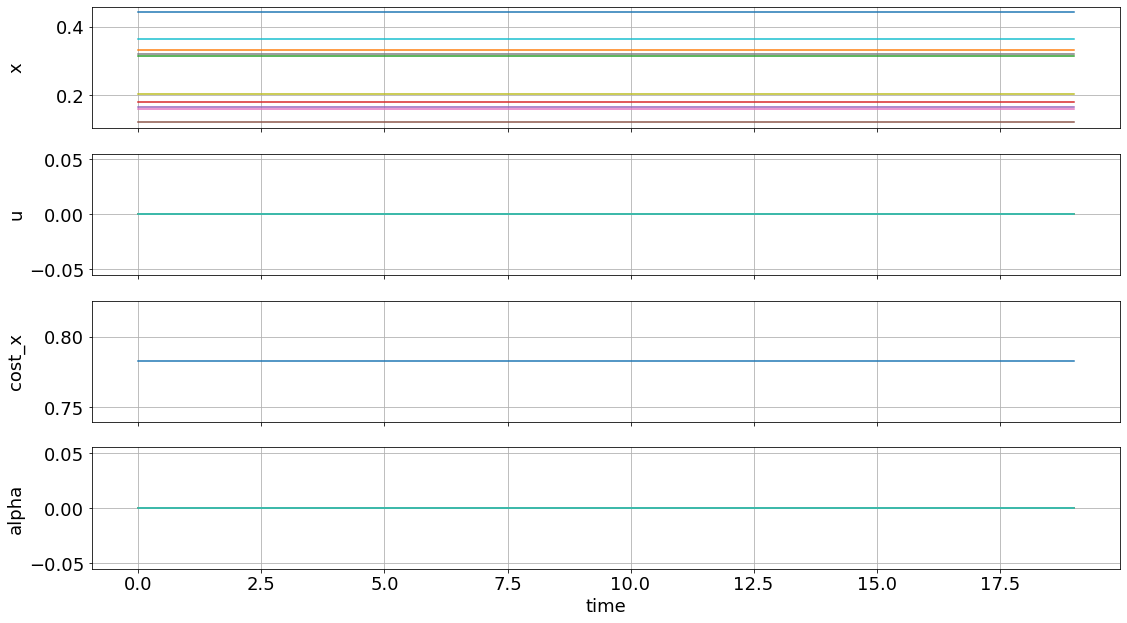

In [79]:
import matplotlib.pyplot as plt
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(16,9))
graphics.reset_axes()
graphics.plot_results()
plt.show()

